### Install dependencies and packages

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image, ImageDraw, ImageFilter
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.metrics import Precision, Recall  # Import the metric classes
import warnings
warnings.filterwarnings('ignore')
from skimage.metrics import structural_similarity as ssim

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow Version: ", tf.__version__)

GPU Available:  []
TensorFlow Version:  2.13.1


In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices())


2.13.1
False
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Configurations

In [ ]:
CONFIG = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'LEARNING_RATE': 0.001,
    'BASE_PATH': './',  # Update this to your dataset path
    'ANONYMIZED_PATH': './anonymized_dataset/',
    'MODEL_SAVE_PATH': './models/',
    'RESULTS_PATH': './results/'
}

# Create directories
os.makedirs(CONFIG['ANONYMIZED_PATH'], exist_ok=True)
os.makedirs(CONFIG['MODEL_SAVE_PATH'], exist_ok=True)
os.makedirs(CONFIG['RESULTS_PATH'], exist_ok=True)

# Updated category mapping based on your actual folder structure
DATASET_FOLDERS = [
    'Accident-1',
    'Damaged-Signs-Multi-label-2', 
    'Graffiti-1',
    'Illegal-Parking-2',
    'branches-road',
    'concrete-damage',
    'damaged-signs-Hind-2',
    'exhaust-detection-2',
    'parking-illegal-final-1-split',
    'pothole-and-speed-breaker-detect-1',
    'urban-trash',
    'water-1'
]

# Mapping from your folders to unified class names
CLASS_MAPPING = {
    # Accident detection
    'Accident Detection - v2 Reannotated-2024-02-20 6-34am': 'accident',
    'Accident Detection - v2 Reannotated-2024-02-20 6-34am_multiple': 'accident',
    'empty': 'no_accident',
    
    # Damaged signs
    'Bending Damage': 'sign_damage',
    'Bending Damage Vandalism': 'sign_damage_vandalism',
    'Bending Damage Vandalism Wear': 'sign_damage_vandalism',
    'Bending Damage Wear': 'sign_damage',
    'Damage Vandalism': 'sign_damage_vandalism', 
    'Damage Vandalism Wear': 'sign_damage_vandalism',
    'Damage Wear': 'sign_damage',
    'Damage': 'sign_damage',
    'Damage_multiple': 'sign_damage',
    'Healthy': 'sign_healthy',
    'Healthy_multiple': 'sign_healthy',
    
    # Graffiti/Vandalism
    '-': 'graffiti',
    '- vandalism - v2 2024-08-07 9-32pm': 'graffiti_vandalism',
    '- vandalism - v2 2024-08-07 9-32pm_multiple': 'graffiti_vandalism',
    '-_multiple': 'graffiti',
    '-_multiple vandalism - v2 2024-08-07 9-32pm': 'graffiti_vandalism',
    '-_multiple vandalism - v2 2024-08-07 9-32pm_multiple': 'graffiti_vandalism',
    'vandalism - v2 2024-08-07 9-32pm': 'graffiti_vandalism',
    'vandalism - v2 2024-08-07 9-32pm_multiple': 'graffiti_vandalism',
    
    # Parking
    'Illegal-parking': 'illegal_parking',
    'Illegal-parking_multiple': 'illegal_parking',
    'illegal': 'illegal_parking',
    'illegal_multiple': 'illegal_parking',
    
    # Road issues
    'branches': 'overgrown_branches',
    'crack': 'road_crack',
    'damage': 'concrete_damage',
    'amage': 'concrete_damage',  # typo in your folder
    'broken road': 'road_damage',
    'broken road potholes': 'pothole',
    'broken road potholes_multiple': 'pothole',
    'broken road_multiple': 'road_damage',
    'broken road_multiple potholes': 'pothole',
    'broken road_multiple potholes_multiple': 'pothole',
    'potholes': 'pothole',
    'potholes_multiple': 'pothole',
    
    # Other
    'exhaust': 'vehicle_exhaust',
    'Domestic_Trash_Garbage': 'trash',
    'dw': 'trash',
    'trash': 'trash',
    'water': 'water_issue'
}

print("Configuration loaded successfully!")
print(f"Found {len(DATASET_FOLDERS)} dataset folders")
print(f"Defined {len(set(CLASS_MAPPING.values()))} unified classes")

Configuration loaded successfully!
Found 12 dataset folders
Defined 16 unified classes


## Image Anonymization

In [ ]:
class ImageAnonymizer:
    """
    Class to handle image anonymization for privacy protection
    """
    def __init__(self):
        # Load pre-trained face detection model
        try:
            self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            print("Face detection model loaded successfully!")
        except:
            print("Warning: Face detection model not found, face anonymization will be skipped")
            self.face_cascade = None
    
    def detect_and_blur_faces(self, image):
        """Detect and blur faces in the image"""
        if self.face_cascade is None:
            return image
            
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)
        
        for (x, y, w, h) in faces:
            # Extract face region and apply Gaussian blur
            face_region = image[y:y+h, x:x+w]
            blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
            image[y:y+h, x:x+w] = blurred_face
        
        return image
    
    def detect_and_blur_license_plates(self, image):
        """Detect and blur potential license plates"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply edge detection
        edges = cv2.Canny(gray, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / h if h > 0 else 0
            
            # License plates typically have aspect ratio between 2:1 and 5:1
            if 2 <= aspect_ratio <= 5 and w > 50 and h > 15:
                # Blur potential license plate region
                plate_region = image[y:y+h, x:x+w]
                blurred_plate = cv2.GaussianBlur(plate_region, (25, 25), 30)
                image[y:y+h, x:x+w] = blurred_plate
        
        return image
    
    def anonymize_image(self, image_path, output_path):
        """Main anonymization function"""
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not read image: {image_path}")
                return False
            
            # Apply face blurring
            image = self.detect_and_blur_faces(image)
            
            # Apply license plate blurring
            image = self.detect_and_blur_license_plates(image)
            
            # Save anonymized image
            cv2.imwrite(output_path, image)
            return True
        except Exception as e:
            print(f"Error anonymizing {image_path}: {str(e)}")
            return False

### Dataset Structure analysis

In [ ]:
def analyze_dataset_structure(base_path):
    """Analyze the multi-dataset structure"""
    print("Dataset Structure Analysis")
    print("=" * 50)
    
    dataset_info = {}
    total_images_per_split = {'train': 0, 'test': 0, 'valid': 0}
    class_distribution = {}
    
    # Analyze each dataset folder
    for dataset_folder in DATASET_FOLDERS:
        dataset_path = os.path.join(base_path, dataset_folder)
        if not os.path.exists(dataset_path):
            print(f"Dataset folder '{dataset_folder}' not found, skipping...")
            continue
            
        print(f"\n{dataset_folder.upper()}:")
        print("-" * len(dataset_folder))
        
        dataset_info[dataset_folder] = {}
        
        # Check each split (train/test/valid)
        for split in ['train', 'test', 'valid']:
            split_path = os.path.join(dataset_path, split)
            if not os.path.exists(split_path):
                continue
                
            split_info = {}
            split_total = 0
            
            # Get all subdirectories (class folders)
            for item in os.listdir(split_path):
                item_path = os.path.join(split_path, item)
                if os.path.isdir(item_path):
                    # Count images in this class folder
                    image_files = [f for f in os.listdir(item_path) 
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    image_count = len(image_files)
                    
                    if image_count > 0:  # Only count non-empty folders
                        split_info[item] = image_count
                        split_total += image_count
                        
                        # Map to unified class name
                        unified_class = CLASS_MAPPING.get(item, item)
                        if unified_class not in class_distribution:
                            class_distribution[unified_class] = {'train': 0, 'test': 0, 'valid': 0}
                        class_distribution[unified_class][split] += image_count
            
            if split_info:
                dataset_info[dataset_folder][split] = split_info
                total_images_per_split[split] += split_total
                print(f"  {split}: {split_total} images in {len(split_info)} classes")
    
    # Print summary
    print(f"\nOVERALL SUMMARY:")
    print("=" * 20)
    for split, total in total_images_per_split.items():
        print(f"{split.capitalize()}: {total} images")
    
    print(f"\nUNIFIED CLASS DISTRIBUTION:")
    print("=" * 30)
    for unified_class, counts in sorted(class_distribution.items()):
        total_class = sum(counts.values())
        print(f"{unified_class}: {total_class} images (Train: {counts['train']}, Test: {counts['test']}, Valid: {counts['valid']})")
    
    return dataset_info, class_distribution

# Analyze your dataset
dataset_info, class_distribution = analyze_dataset_structure(CONFIG['BASE_PATH'])

Dataset Structure Analysis

ACCIDENT-1:
----------
  train: 253 images in 3 classes
  test: 47 images in 2 classes
  valid: 166 images in 2 classes

DAMAGED-SIGNS-MULTI-LABEL-2:
---------------------------
  train: 1647 images in 8 classes
  test: 30 images in 6 classes
  valid: 116 images in 8 classes

GRAFFITI-1:
----------
  train: 1704 images in 8 classes
  test: 210 images in 8 classes
  valid: 214 images in 7 classes

ILLEGAL-PARKING-2:
-----------------
  train: 16 images in 2 classes
  test: 6 images in 2 classes
  valid: 3 images in 2 classes

BRANCHES-ROAD:
-------------
  train: 574 images in 1 classes
  test: 82 images in 1 classes
  valid: 164 images in 1 classes

CONCRETE-DAMAGE:
---------------
  train: 1867 images in 3 classes
  test: 268 images in 2 classes
  valid: 533 images in 2 classes

DAMAGED-SIGNS-HIND-2:
--------------------
  train: 2140 images in 5 classes
  test: 134 images in 2 classes
  valid: 135 images in 3 classes

EXHAUST-DETECTION-2:
-----------------

### Dataset Structure

In [ ]:
def create_unified_dataset(input_base_path, output_base_path, anonymize=True):
    """Create a unified dataset structure from multiple dataset folders"""
    
    if anonymize:
        anonymizer = ImageAnonymizer()
        print("Creating unified anonymized dataset...")
    else:
        print("Creating unified dataset (no anonymization)...")
    
    print("=" * 50)
    
    # Create output structure
    for split in ['train', 'test', 'valid']:
        os.makedirs(os.path.join(output_base_path, split), exist_ok=True)
    
    # Get unique classes from mapping
    unique_classes = set(CLASS_MAPPING.values())
    for split in ['train', 'test', 'valid']:
        for unified_class in unique_classes:
            os.makedirs(os.path.join(output_base_path, split, unified_class), exist_ok=True)
    
    processed_count = 0
    skipped_count = 0
    
    # Process each dataset folder
    for dataset_folder in DATASET_FOLDERS:
        dataset_path = os.path.join(input_base_path, dataset_folder)
        if not os.path.exists(dataset_path):
            continue
            
        print(f"\nProcessing {dataset_folder}...")
        
        # Process each split
        for split in ['train', 'test', 'valid']:
            split_path = os.path.join(dataset_path, split)
            if not os.path.exists(split_path):
                continue
                
            # Process each class folder
            for class_folder in os.listdir(split_path):
                class_path = os.path.join(split_path, class_folder)
                if not os.path.isdir(class_path):
                    continue
                
                # Skip tokenization files and other non-class folders
                if class_folder.startswith('_') or class_folder.endswith('.txt'):
                    continue
                
                # Get unified class name
                unified_class = CLASS_MAPPING.get(class_folder, class_folder)
                output_class_path = os.path.join(output_base_path, split, unified_class)
                
                # Process images in this class
                image_files = [f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                for image_file in image_files:
                    input_image_path = os.path.join(class_path, image_file)
                    
                    # Create unique filename to avoid conflicts
                    base_name, ext = os.path.splitext(image_file)
                    unique_filename = f"{dataset_folder}_{class_folder}_{base_name}{ext}"
                    output_image_path = os.path.join(output_class_path, unique_filename)
                    
                    try:
                        if anonymize:
                            success = anonymizer.anonymize_image(input_image_path, output_image_path)
                        else:
                            # Just copy the image
                            import shutil
                            shutil.copy2(input_image_path, output_image_path)
                            success = True
                        
                        if success:
                            processed_count += 1
                        else:
                            skipped_count += 1
                            
                    except Exception as e:
                        print(f"Error processing {input_image_path}: {str(e)}")
                        skipped_count += 1
                
                if len(image_files) > 0:
                    print(f"  {split}/{class_folder} -> {unified_class}: {len(image_files)} images")
    
    print(f"\nUnified dataset creation complete!")
    print(f"Processed: {processed_count} images")
    print(f"Skipped: {skipped_count} images")
    
    return processed_count, skipped_count

# Create unified dataset (with anonymization)
processed_images, skipped_images = create_unified_dataset(
    CONFIG['BASE_PATH'], 
    CONFIG['ANONYMIZED_PATH'], 
    anonymize=True
)

## Data Loading and Preprocessing

In [ ]:
def create_data_generators(dataset_path, img_size, batch_size):
    """Create data generators for training, validation, and testing"""
    
    import os
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    # Check if unified dataset exists
    train_path = os.path.join(dataset_path, 'train')
    valid_path = os.path.join(dataset_path, 'valid') 
    test_path = os.path.join(dataset_path, 'test')
    
    if not all(os.path.exists(p) for p in [train_path, valid_path, test_path]):
        raise ValueError(f"Unified dataset not found at {dataset_path}. Please run the unified dataset creation first.")
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # No augmentation for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    
    valid_generator = val_test_datagen.flow_from_directory(
        valid_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, valid_generator, test_generator

# Hardcoded parameters
HARDCODED_IMG_SIZE = (224, 224)
HARDCODED_BATCH_SIZE = 32

print("Creating data generators...")
try:
    train_gen, valid_gen, test_gen = create_data_generators(
        CONFIG['ANONYMIZED_PATH'],   # still using path from CONFIG
        HARDCODED_IMG_SIZE,          # hardcoded img size here
        HARDCODED_BATCH_SIZE         # hardcoded batch size here
    )
    
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {valid_gen.samples}")
    print(f"Test samples: {test_gen.samples}")
    print(f"Number of classes: {train_gen.num_classes}")
    print(f"Class names: {list(train_gen.class_indices.keys())}")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Please ensure the unified dataset has been created successfully.")


Creating data generators...
Found 14478 images belonging to 16 classes.
Found 1864 images belonging to 16 classes.
Found 1208 images belonging to 16 classes.
Training samples: 14478
Validation samples: 1864
Test samples: 1208
Number of classes: 16
Class names: ['accident', 'concrete_damage', 'graffiti', 'graffiti_vandalism', 'illegal_parking', 'no_accident', 'overgrown_branches', 'pothole', 'road_crack', 'road_damage', 'sign_damage', 'sign_damage_vandalism', 'sign_healthy', 'trash', 'vehicle_exhaust', 'water_issue']


sample images

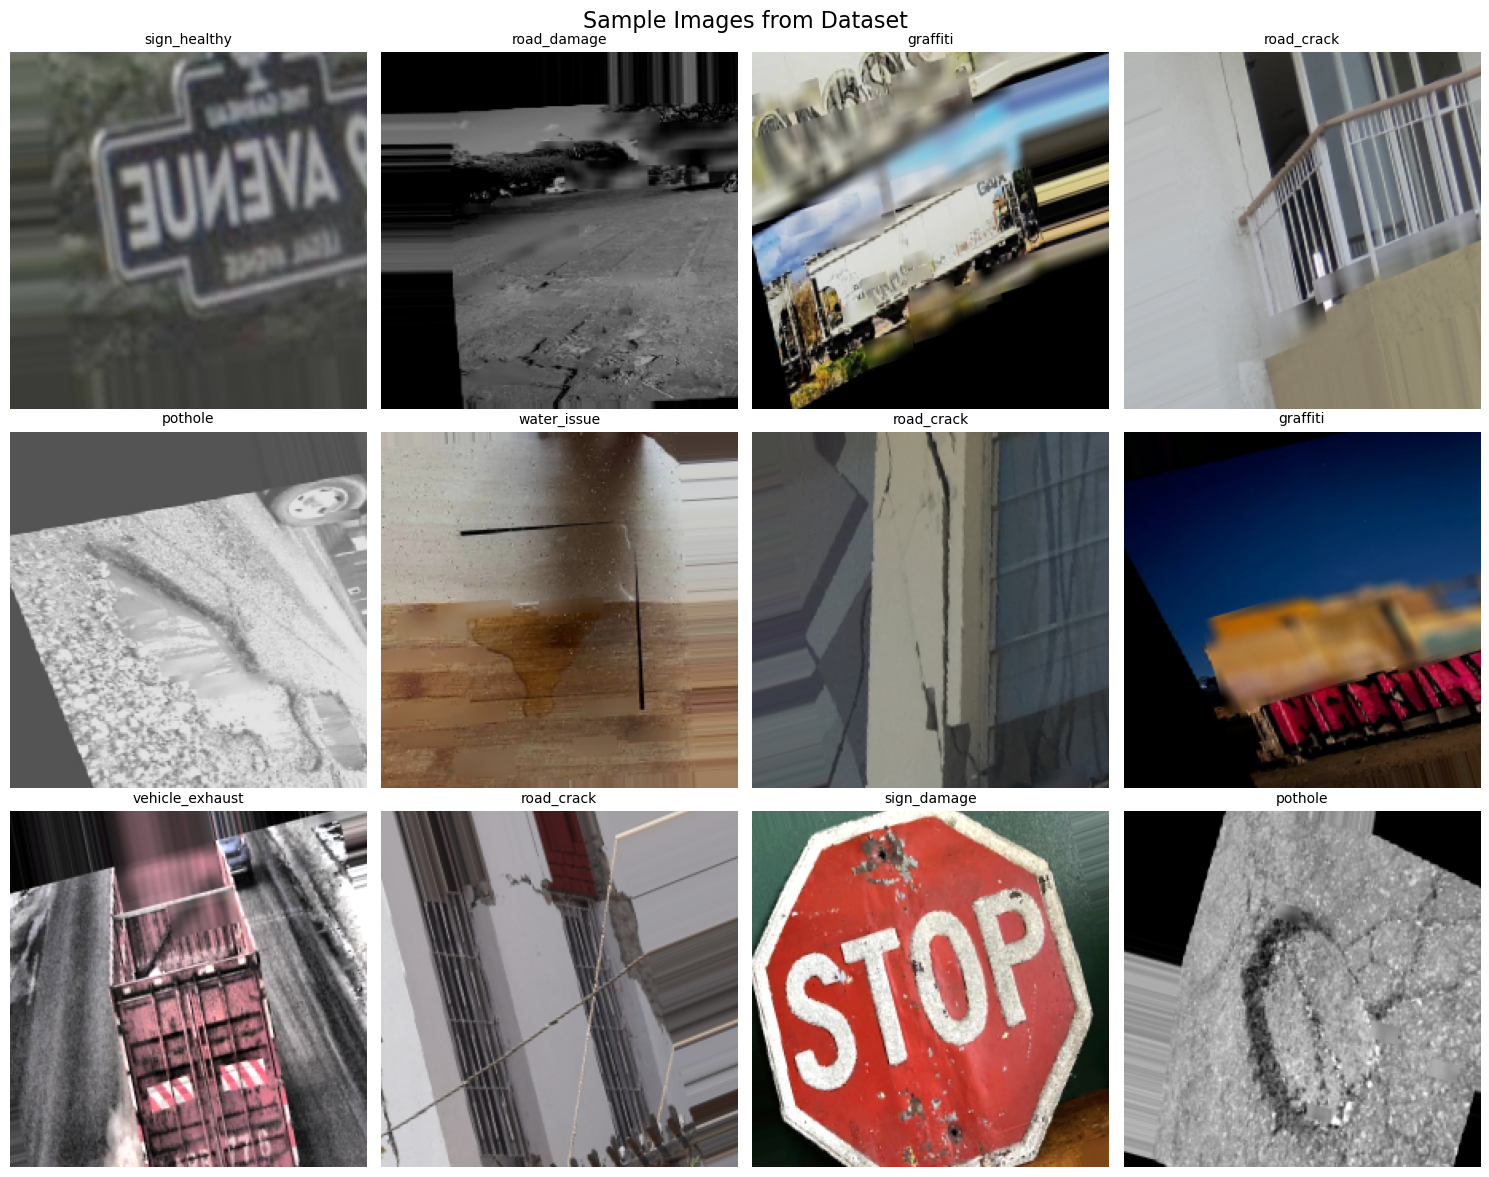

In [ ]:
def visualize_sample_images(generator, num_samples=12):
    """Visualize sample images from the dataset"""
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    fig.suptitle('Sample Images from Dataset', fontsize=16)
    
    # Get a batch of images
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    
    for i in range(min(num_samples, len(images))):
        row = i // 4
        col = i % 4
        
        # Display image
        axes[row, col].imshow(images[i])
        axes[row, col].axis('off')
        
        # Get class name
        class_idx = np.argmax(labels[i])
        class_name = class_names[class_idx]
        axes[row, col].set_title(f'{class_name}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
visualize_sample_images(train_gen)

Model Architecture define

In [ ]:
def create_model(input_shape, num_classes):
    """Create the classification model"""
    
    # Load EfficientNetB0
    base_model = EfficientNetB0(
        weights='None',
        include_top=False,
        input_shape=input_shape
    )
    
    
    base_model.trainable = False
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
input_shape = (*CONFIG['IMG_SIZE'], 3)
num_classes = train_gen.num_classes

model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Print model summary
print("Model Architecture:")
print("=" * 50)
model.summary()

16705208/16705208 [==============================] - 33s 2us/step
Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                     

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(CONFIG['MODEL_SAVE_PATH'], 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Training callbacks configured:")
print("- Early Stopping (patience=10)")
print("- Learning Rate Reduction (patience=5)")
print("- Model Checkpoint (save best model)")

Training callbacks configured:
- Early Stopping (patience=10)
- Learning Rate Reduction (patience=5)
- Model Checkpoint (save best model)


In [2]:
print("Recompiling model with proper metrics...")

# Recompile the model with proper metric objects
model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='accuracy'),
        TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

print("Model recompiled successfully!")
print("Model summary:")
model.summary()


print("\nModel metrics:", model.metrics_names)

print("\nStarting Phase 1 Training (Frozen Base Model)...")
print("=" * 60)


print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {valid_gen.samples}")
print(f"Batch size: {CONFIG['BATCH_SIZE']}")
print(f"Steps per epoch: {train_gen.samples // CONFIG['BATCH_SIZE']}")
print(f"Validation steps: {valid_gen.samples // CONFIG['BATCH_SIZE']}")


try:
    history_phase1 = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // CONFIG['BATCH_SIZE'],
        epochs=15,  # Initial training with frozen base
        validation_data=valid_gen,
        validation_steps=valid_gen.samples // CONFIG['BATCH_SIZE'],
        callbacks=callbacks,
        verbose=1
    )
    print("Phase 1 training completed successfully!")

except Exception as e:
    print(f"Training failed with error: {e}")
    print("Checking model and data generators...")

    # Debug information
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")

    # Test a single batch
    try:
        batch_x, batch_y = next(train_gen)
        print(f"Batch input shape: {batch_x.shape}")
        print(f"Batch output shape: {batch_y.shape}")
        print(f"Batch input dtype: {batch_x.dtype}")
        print(f"Batch output dtype: {batch_y.dtype}")

        # Test model prediction on batch
        pred = model.predict(batch_x[:1])
        print(f"Prediction shape: {pred.shape}")

    except Exception as batch_error:
        print(f"Batch error: {batch_error}")

# Alternative compilation if the above doesn't work
print("\n" + "="*60)
print("If the error persists, try this alternative compilation:")
print("="*60)

# More explicit metric compilation
try:
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']  # Using string names which should work
    )
    print("Alternative compilation successful!")

    # Try training again with simpler setup
    history_phase1 = model.fit(
        train_gen,
        steps_per_epoch=min(50, train_gen.samples // CONFIG['BATCH_SIZE']),  # Limit initial steps
        epochs=2,  # Start with fewer epochs for testing
        validation_data=valid_gen,
        validation_steps=min(20, valid_gen.samples // CONFIG['BATCH_SIZE']),
        verbose=1
    )
    print("Alternative training successful!")

except Exception as alt_error:
    print(f"Alternative approach also failed: {alt_error}")

    # Last resort: rebuild the model
    print("Attempting to rebuild the model...")

    # Clear any existing model
    del model
    import gc
    gc.collect()

    # Create base model WITHOUT pretrained weights
    base_model = EfficientNetB0(
        weights=None, 
        include_top=False,
        input_shape=CONFIG['IMG_SIZE'] + (3,)
    )

    
    base_model.trainable = False

    # custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(CONFIG['NUM_CLASSES'], activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

  
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model rebuilt from scratch and compiled successfully!")
    print("You can now retry the training.")

Recompiling model with proper metrics...


NameError: name 'model' is not defined

In [6]:



# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE'] * 0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]  # Use metric classes instead of strings
)

# Continue training with unfrozen base
history_phase2 = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // CONFIG['BATCH_SIZE'],
    epochs=25,  # Additional epochs for fine-tuning
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // CONFIG['BATCH_SIZE'],
    callbacks=callbacks,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])
)

print("Phase 2 training completed!")

NameError: name 'model' is not defined

Available metrics in training history:
  loss: 25 epochs
  accuracy: 25 epochs
  val_loss: 25 epochs
  val_accuracy: 25 epochs


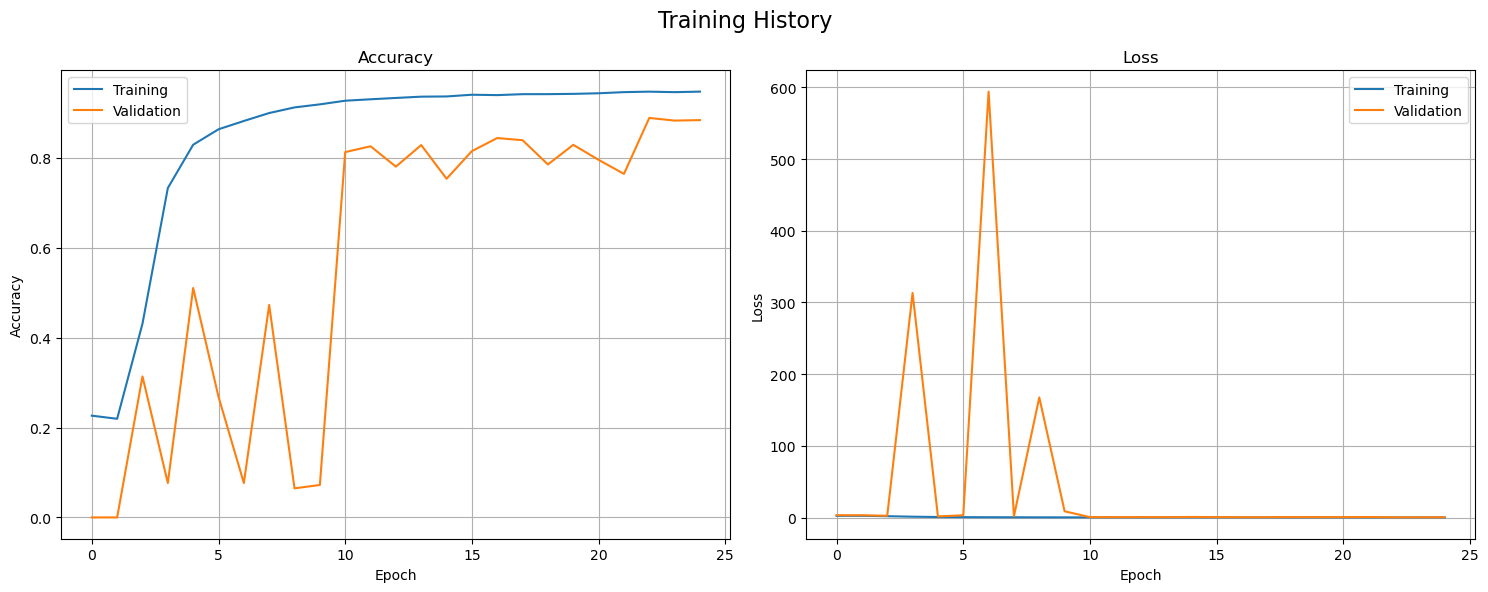

In [ ]:
def combine_histories(hist1, hist2):
    """Combine two training histories"""
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

# Combine training histories
combined_history = combine_histories(history_phase1, history_phase2)

def plot_training_history(history):
    """Plot training history with flexible metric handling"""
    # Check which metrics are available
    available_metrics = list(history.keys())
    
    # Define metric pairs (training, validation)
    metric_pairs = [
        ('accuracy', 'val_accuracy', 'Accuracy'),
        ('loss', 'val_loss', 'Loss'),
        ('precision', 'val_precision', 'Precision'),
        ('recall', 'val_recall', 'Recall')
    ]
    
    # Filter to only available metrics
    available_pairs = []
    for train_metric, val_metric, title in metric_pairs:
        if train_metric in available_metrics and val_metric in available_metrics:
            available_pairs.append((train_metric, val_metric, title))
    
    # Determine subplot layout
    n_plots = len(available_pairs)
    if n_plots == 0:
        print("No training/validation metric pairs found!")
        return
    
    # Calculate subplot dimensions
    if n_plots == 1:
        rows, cols = 1, 1
        figsize = (8, 6)
    elif n_plots == 2:
        rows, cols = 1, 2
        figsize = (15, 6)
    elif n_plots <= 4:
        rows, cols = 2, 2
        figsize = (15, 10)
    else:
        rows = (n_plots + 2) // 3
        cols = 3
        figsize = (15, 5 * rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    fig.suptitle('Training History', fontsize=16)
    
    # Plot each available metric
    for i, (train_metric, val_metric, title) in enumerate(available_pairs):
        axes[i].plot(history[train_metric], label='Training')
        axes[i].plot(history[val_metric], label='Validation')
        axes[i].set_title(title)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(title)
        axes[i].legend()
        axes[i].grid(True)
    
    # Hide unused subplots
    for i in range(len(available_pairs), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_basic_training_history(history):
    """Plot basic training history (accuracy and loss only)"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Training History', fontsize=16)
    
    # Accuracy
    if 'accuracy' in history and 'val_accuracy' in history:
        ax1.plot(history['accuracy'], label='Training')
        ax1.plot(history['val_accuracy'], label='Validation')
        ax1.set_title('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
    
    # Loss
    if 'loss' in history and 'val_loss' in history:
        ax2.plot(history['loss'], label='Training')
        ax2.plot(history['val_loss'], label='Validation')
        ax2.set_title('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Check what metrics are available
print("Available metrics in training history:")
for key in combined_history.keys():
    print(f"  {key}: {len(combined_history[key])} epochs")

# Plot training history (will adapt to available metrics)
plot_training_history(combined_history)

# If you prefer the simple version with just accuracy and loss:
# plot_basic_training_history(combined_history)

In [40]:
def evaluate_model(model, test_generator):
    """
    Comprehensive model evaluation with proper class handling
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    import numpy as np
    
    print("Evaluating model on test set...")
    print("=" * 50)
    
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true classes
    true_classes = test_generator.classes
    
    # Get class names from generator
    class_names = list(test_generator.class_indices.keys())
    
    # Debug information
    print(f"\nDebug Information:")
    print(f"Number of test samples: {len(true_classes)}")
    print(f"Number of class names: {len(class_names)}")
    print(f"Unique classes in true_classes: {sorted(np.unique(true_classes))}")
    print(f"Unique classes in predicted_classes: {sorted(np.unique(predicted_classes))}")
    print(f"Class names: {class_names}")
    
    # Check for class mismatch
    unique_true = set(true_classes)
    unique_pred = set(predicted_classes)
    all_classes = sorted(unique_true.union(unique_pred))
    
    print(f"All unique classes found: {all_classes}")
    print(f"Expected classes (0 to {len(class_names)-1}): {list(range(len(class_names)))}")
    
    # Calculate basic metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    
    print(f"\nOverall Metrics:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    
    # Classification report with proper handling
    print("\nDetailed Classification Report:")
    print("=" * 50)
    
    try:
        # Method 1: Use only the classes that appear in the data
        labels_present = sorted(unique_true.union(unique_pred))
        target_names_present = [class_names[i] if i < len(class_names) else f"Unknown_{i}" 
                               for i in labels_present]
        
        print("Classification Report (classes present in test data):")
        print(classification_report(true_classes, predicted_classes, 
                                  labels=labels_present,
                                  target_names=target_names_present,
                                  zero_division=0))
        
    except Exception as e:
        print(f"Error with method 1: {e}")
        
        # Method 2: Fallback - use all expected classes
        try:
            print("\nClassification Report (all classes):")
            all_labels = list(range(len(class_names)))
            print(classification_report(true_classes, predicted_classes, 
                                      labels=all_labels,
                                      target_names=class_names,
                                      zero_division=0))
        except Exception as e2:
            print(f"Error with method 2: {e2}")
            
            # Method 3: Basic report without target names
            print("\nBasic Classification Report (without class names):")
            print(classification_report(true_classes, predicted_classes, zero_division=0))
    
    # Additional analysis
    print(f"\nClass Distribution Analysis:")
    print("=" * 30)
    
    # True class distribution
    true_counts = np.bincount(true_classes)
    print("True class distribution:")
    for i, count in enumerate(true_counts):
        if count > 0:
            class_name = class_names[i] if i < len(class_names) else f"Unknown_{i}"
            print(f"  {class_name} (class {i}): {count} samples")
    
    # Predicted class distribution
    pred_counts = np.bincount(predicted_classes, minlength=len(class_names))
    print("\nPredicted class distribution:")
    for i, count in enumerate(pred_counts):
        if count > 0:
            class_name = class_names[i] if i < len(class_names) else f"Unknown_{i}"
            print(f"  {class_name} (class {i}): {count} predictions")
    
    # Check for missing classes
    missing_in_true = set(range(len(class_names))) - unique_true
    missing_in_pred = set(range(len(class_names))) - unique_pred
    
    if missing_in_true:
        print(f"\nClasses missing from test set: {[class_names[i] for i in missing_in_true]}")
    if missing_in_pred:
        print(f"Classes never predicted: {[class_names[i] for i in missing_in_pred]}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': predictions,
        'predicted_classes': predicted_classes,
        'true_classes': true_classes,
        'class_names': class_names,
        'unique_classes_true': sorted(unique_true),
        'unique_classes_pred': sorted(unique_pred),
        'class_distribution_true': true_counts,
        'class_distribution_pred': pred_counts
    }

# Additional helper function to diagnose data generator issues
def diagnose_generator(generator, name="Generator"):
    """Diagnose potential issues with data generator"""
    print(f"\n{name} Diagnosis:")
    print("=" * 30)
    print(f"Number of samples: {generator.samples}")
    print(f"Number of classes: {generator.num_classes}")
    print(f"Class indices: {generator.class_indices}")
    print(f"Classes array length: {len(generator.classes)}")
    print(f"Unique values in classes: {sorted(np.unique(generator.classes))}")
    
    # Check if all class indices are represented
    expected_classes = set(range(generator.num_classes))
    actual_classes = set(generator.classes)
    missing_classes = expected_classes - actual_classes
    
    if missing_classes:
        print(f"WARNING: Missing classes in {name.lower()}: {missing_classes}")
        missing_names = [list(generator.class_indices.keys())[i] for i in missing_classes]
        print(f"Missing class names: {missing_names}")
    
    return {
        'samples': generator.samples,
        'num_classes': generator.num_classes,
        'class_indices': generator.class_indices,
        'unique_classes': sorted(np.unique(generator.classes)),
        'missing_classes': missing_classes
    }

# Diagnose the test generator first
diagnose_generator(test_gen, "Test Generator")

# Now evaluate the model
evaluation_results = evaluate_model(model, test_gen)


Test Generator Diagnosis:
Number of samples: 1208
Number of classes: 16
Class indices: {'accident': 0, 'concrete_damage': 1, 'graffiti': 2, 'graffiti_vandalism': 3, 'illegal_parking': 4, 'no_accident': 5, 'overgrown_branches': 6, 'pothole': 7, 'road_crack': 8, 'road_damage': 9, 'sign_damage': 10, 'sign_damage_vandalism': 11, 'sign_healthy': 12, 'trash': 13, 'vehicle_exhaust': 14, 'water_issue': 15}
Classes array length: 1208
Unique values in classes: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Missing class names: ['no_accident']
Evaluating model on test set...
38/38 [==============================] - 26s 692ms/step

Debug Information:
Number of test samples: 1208
Number of class names: 16
Unique classes in true_classes: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Unique classes in predicted_classes: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Class names: ['accident', 'concrete_damage', 'graffiti', 'graffiti_vandalism', 'illegal_parking', 'no_accident', 'overg

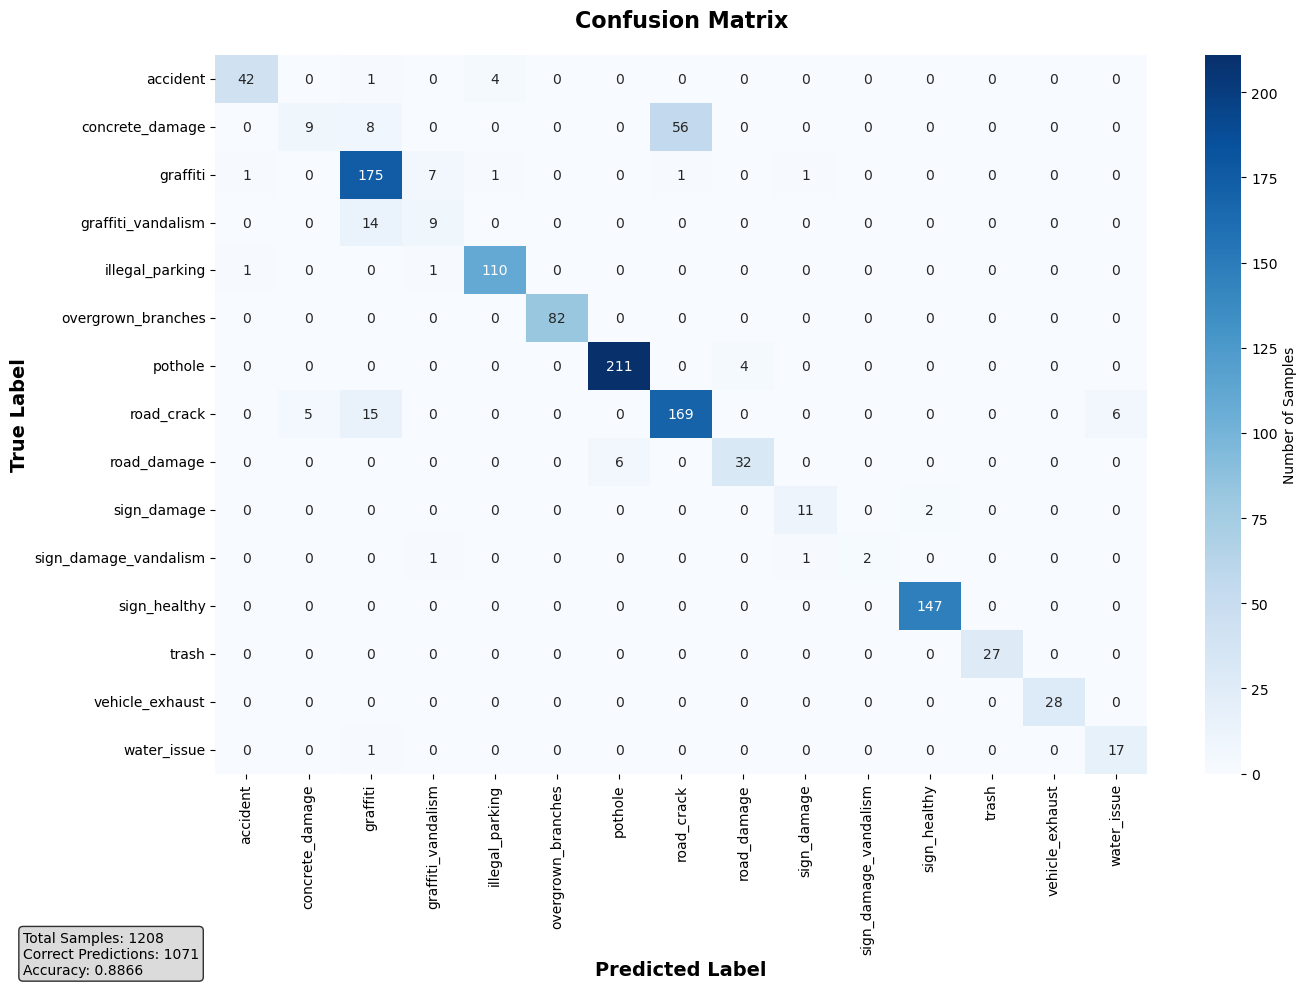

Confusion Matrix Shape: (15, 15)
Total Samples: 1208
Classes in matrix: 15
Available class names: 16


In [ ]:
def plot_confusion_matrix(true_classes, predicted_classes, class_names, figsize=(14, 10)):
    """Plot confusion matrix with 90-degree rotated x-axis labels"""
    

    unique_classes = sorted(set(true_classes) | set(predicted_classes))
    
    # Filter class names to match available classes
    filtered_class_names = []
    for class_idx in unique_classes:
        if class_idx < len(class_names):
            filtered_class_names.append(class_names[class_idx])
        else:
            filtered_class_names.append(f"Class_{class_idx}")
    
  
    cm = confusion_matrix(true_classes, predicted_classes, labels=unique_classes)

    plt.figure(figsize=figsize)
    

    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=filtered_class_names, 
                     yticklabels=filtered_class_names,
                     cbar_kws={'label': 'Number of Samples'})
    
   
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    
   
    plt.xticks(rotation=90, ha='center', fontsize=10)
    plt.yticks(rotation=0, ha='right', fontsize=10)

    plt.tight_layout()
    
    total_samples = np.sum(cm)
    correct_predictions = np.trace(cm)
    accuracy = correct_predictions / total_samples
    
    plt.figtext(0.02, 0.02, f'Total Samples: {total_samples}\nCorrect Predictions: {correct_predictions}\nAccuracy: {accuracy:.4f}', 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.show()
    
    print(f"Confusion Matrix Shape: {cm.shape}")
    print(f"Total Samples: {total_samples}")
    print(f"Classes in matrix: {len(unique_classes)}")
    print(f"Available class names: {len(class_names)}")
    
    return cm

def plot_confusion_matrix_percentage(true_classes, predicted_classes, class_names, figsize=(14, 10)):
    """Plot confusion matrix with percentages and 90-degree rotated x-axis labels"""
    
    # Handle class mismatch by using only classes present in the data
    unique_classes = sorted(set(true_classes) | set(predicted_classes))
    
    # Filter class names to match available classes
    filtered_class_names = []
    for class_idx in unique_classes:
        if class_idx < len(class_names):
            filtered_class_names.append(class_names[class_idx])
        else:
            filtered_class_names.append(f"Class_{class_idx}")
    
    # Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes, labels=unique_classes)
    
 
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]))
    

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=filtered_class_names, 
                yticklabels=filtered_class_names,
                ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=90, labelsize=9)
    ax1.tick_params(axis='y', rotation=0, labelsize=9)

    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Reds', 
                xticklabels=filtered_class_names, 
                yticklabels=filtered_class_names,
                ax=ax2, cbar_kws={'label': 'Percentage (%)'})
    ax2.set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=90, labelsize=9)
    ax2.tick_params(axis='y', rotation=0, labelsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return cm, cm_percent

confusion_mat = plot_confusion_matrix(
    evaluation_results['true_classes'], 
    evaluation_results['predicted_classes'], 
    evaluation_results['class_names']
)


Per-Class Performance Analysis
Total class names provided: 16
Unique classes in data: 15
Classes present: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Per-Class Performance (Classes Present in Data):
------------------------------------------------------------
 Class_Index            Class_Name  Precision  Recall  F1-Score
           0              accident     0.9545  0.8936    0.9231
           1       concrete_damage     0.6429  0.1233    0.2069
           2              graffiti     0.8178  0.9409    0.8750
           3    graffiti_vandalism     0.5000  0.3913    0.4390
           4       illegal_parking     0.9565  0.9821    0.9692
           6    overgrown_branches     1.0000  1.0000    1.0000
           7               pothole     0.9724  0.9814    0.9769
           8            road_crack     0.7478  0.8667    0.8029
           9           road_damage     0.8889  0.8421    0.8649
          10           sign_damage     0.8462  0.8462    0.8462
          11 sign_damage_va

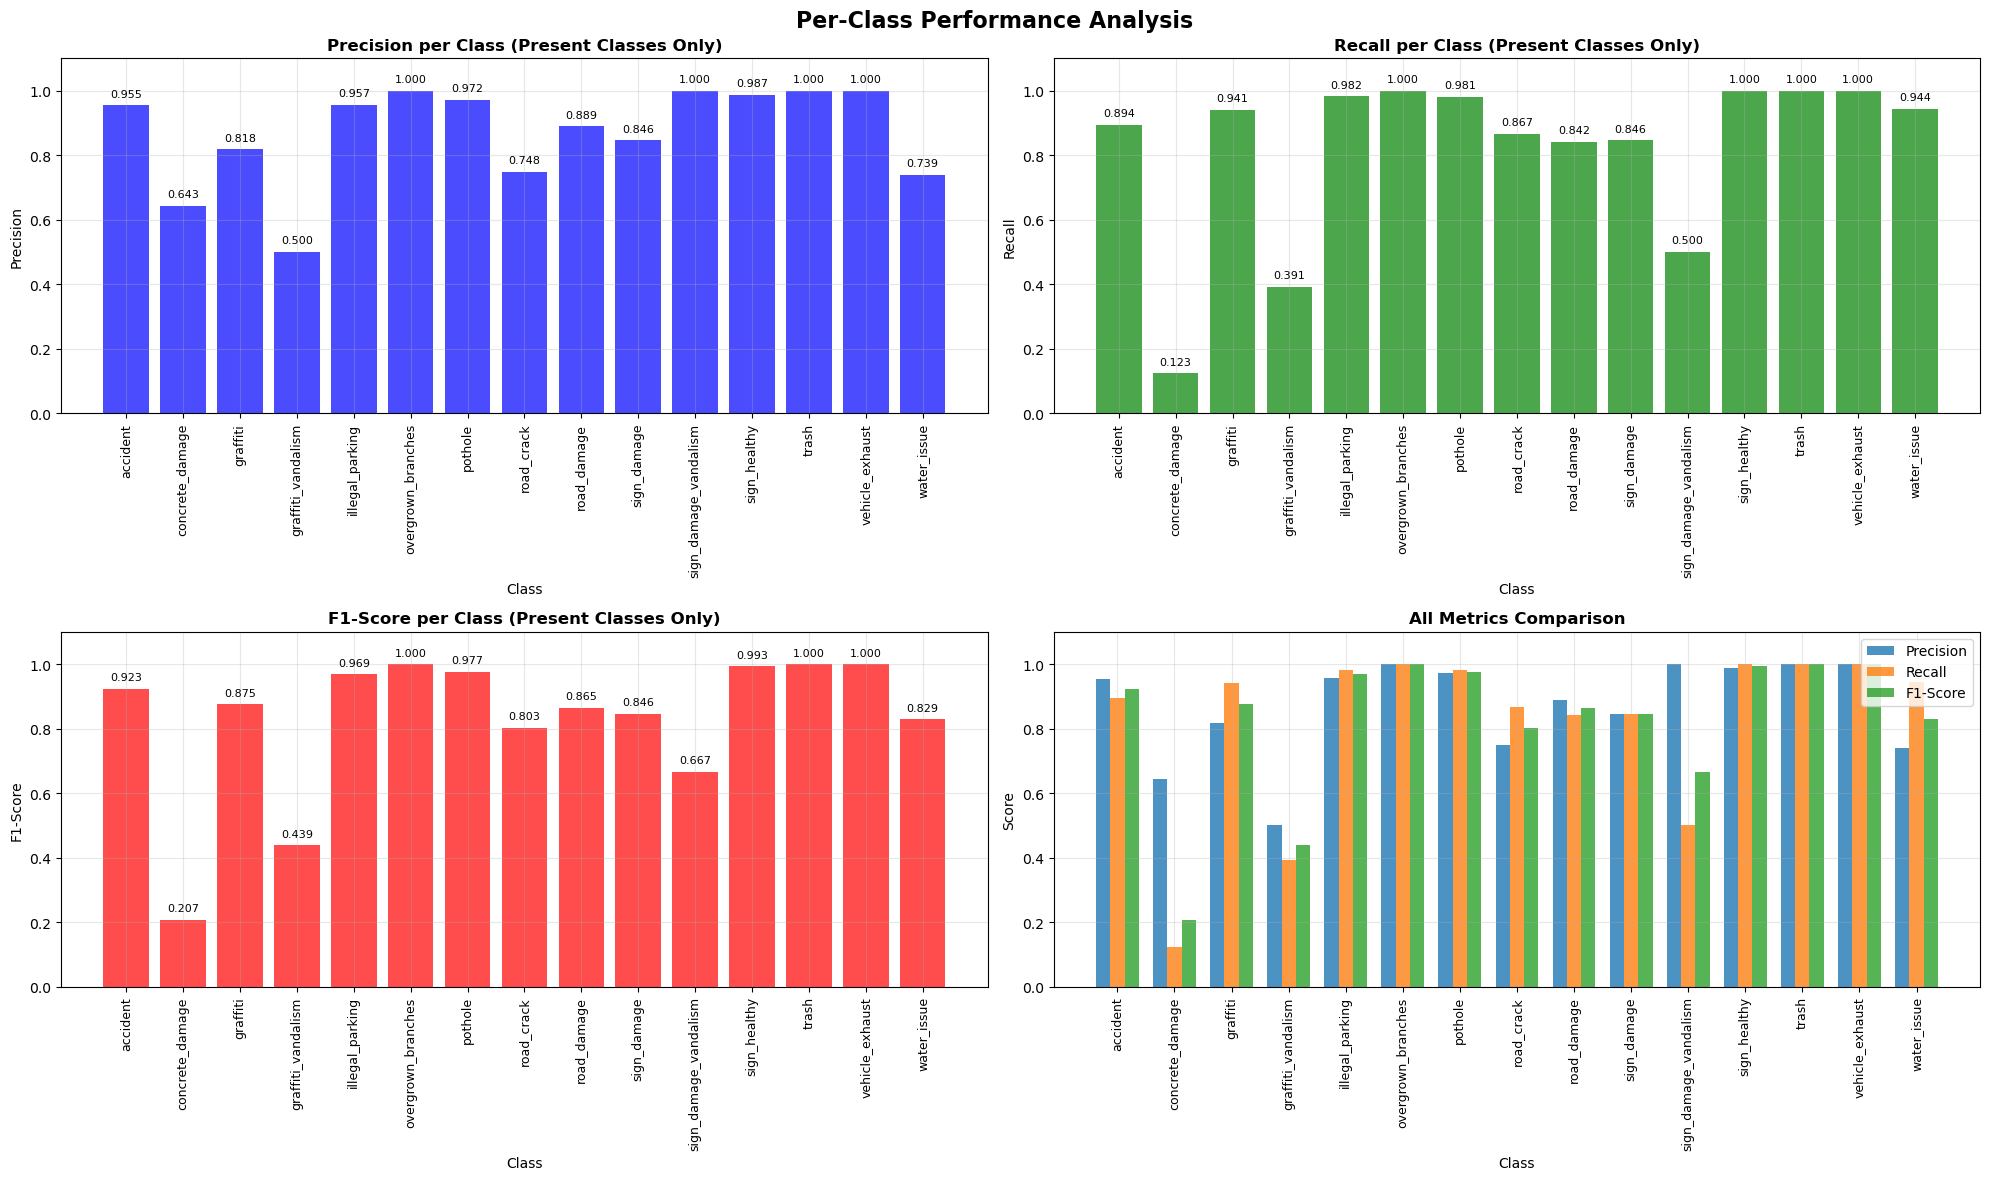


Performance Summary:
------------------------------
Best performing class (F1): overgrown_branches (F1: 1.0000)
Worst performing class (F1): concrete_damage (F1: 0.2069)
Average F1-Score: 0.8262
Standard deviation F1-Score: 0.2213

Classes with F1-Score < 0.5:
  concrete_damage: F1=0.2069
  graffiti_vandalism: F1=0.4390


In [ ]:
def analyze_per_class_performance(true_classes, predicted_classes, class_names):
    """Analyze performance for each class with proper handling of missing classes"""
    
    print("Per-Class Performance Analysis")
    print("=" * 50)
    
    # Get unique classes that actually appear in the data
    unique_true = set(true_classes)
    unique_pred = set(predicted_classes)
    all_unique_classes = sorted(unique_true.union(unique_pred))
    
    print(f"Total class names provided: {len(class_names)}")
    print(f"Unique classes in data: {len(all_unique_classes)}")
    print(f"Classes present: {all_unique_classes}")
    
    
    try:
        precision_per_class = precision_score(true_classes, predicted_classes, 
                                            average=None, labels=all_unique_classes, zero_division=0)
        recall_per_class = recall_score(true_classes, predicted_classes, 
                                      average=None, labels=all_unique_classes, zero_division=0)
        f1_per_class = f1_score(true_classes, predicted_classes, 
                              average=None, labels=all_unique_classes, zero_division=0)
        
        # Create corresponding class names for the metrics
        present_class_names = []
        for class_idx in all_unique_classes:
            if class_idx < len(class_names):
                present_class_names.append(class_names[class_idx])
            else:
                present_class_names.append(f"Class_{class_idx}")
        
        # Create dataframe for classes present in data
        performance_df = pd.DataFrame({
            'Class_Index': all_unique_classes,
            'Class_Name': present_class_names,
            'Precision': precision_per_class,
            'Recall': recall_per_class,
            'F1-Score': f1_per_class
        })
        
        print("\nPer-Class Performance (Classes Present in Data):")
        print("-" * 60)
        print(performance_df.round(4).to_string(index=False))
        
        comprehensive_df = pd.DataFrame({
            'Class_Index': range(len(class_names)),
            'Class_Name': class_names,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'Present_in_Data': False
        })
        
       
        for i, class_idx in enumerate(all_unique_classes):
            if class_idx < len(class_names):
                comprehensive_df.loc[class_idx, 'Precision'] = precision_per_class[i]
                comprehensive_df.loc[class_idx, 'Recall'] = recall_per_class[i]
                comprehensive_df.loc[class_idx, 'F1-Score'] = f1_per_class[i]
                comprehensive_df.loc[class_idx, 'Present_in_Data'] = True
        
        print(f"\nComprehensive Performance (All {len(class_names)} Classes):")
        print("-" * 60)
        print("Note: NaN values indicate classes not present in test data")
        print(comprehensive_df.round(4).to_string(index=False))
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        fig.suptitle('Per-Class Performance Analysis', fontsize=16, fontweight='bold')
        
       
        metrics = ['Precision', 'Recall', 'F1-Score']
        x_pos = np.arange(len(present_class_names))
        
        for i, metric in enumerate(metrics):
            if i < 3:  # First three subplots
                row = i // 2
                col = i % 2
                axes[row, col].bar(x_pos, performance_df[metric], alpha=0.7, 
                                 color=['blue', 'green', 'red'][i])
                axes[row, col].set_title(f'{metric} per Class (Present Classes Only)', 
                                       fontsize=12, fontweight='bold')
                axes[row, col].set_xlabel('Class', fontsize=10)
                axes[row, col].set_ylabel(metric, fontsize=10)
                axes[row, col].set_xticks(x_pos)
                axes[row, col].set_xticklabels(present_class_names, rotation=90, ha='center', fontsize=9)
                axes[row, col].grid(True, alpha=0.3)
                axes[row, col].set_ylim(0, 1.1)
                
             
                for j, v in enumerate(performance_df[metric]):
                    if not np.isnan(v):
                        axes[row, col].text(j, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
        
       
        width = 0.25
        x = np.arange(len(present_class_names))
        axes[1, 1].bar(x - width, performance_df['Precision'], width, label='Precision', alpha=0.8)
        axes[1, 1].bar(x, performance_df['Recall'], width, label='Recall', alpha=0.8)
        axes[1, 1].bar(x + width, performance_df['F1-Score'], width, label='F1-Score', alpha=0.8)
        
        axes[1, 1].set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Class', fontsize=10)
        axes[1, 1].set_ylabel('Score', fontsize=10)
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(present_class_names, rotation=90, ha='center', fontsize=9)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_ylim(0, 1.1)
        
        plt.tight_layout()
        plt.show()
        
      
        print(f"\nPerformance Summary:")
        print("-" * 30)
        print(f"Best performing class (F1): {present_class_names[np.argmax(performance_df['F1-Score'])]} "
              f"(F1: {np.max(performance_df['F1-Score']):.4f})")
        print(f"Worst performing class (F1): {present_class_names[np.argmin(performance_df['F1-Score'])]} "
              f"(F1: {np.min(performance_df['F1-Score']):.4f})")
        print(f"Average F1-Score: {np.mean(performance_df['F1-Score']):.4f}")
        print(f"Standard deviation F1-Score: {np.std(performance_df['F1-Score']):.4f}")
        
        # Identify problematic classes
        low_f1_threshold = 0.5
        low_f1_classes = performance_df[performance_df['F1-Score'] < low_f1_threshold]
        if not low_f1_classes.empty:
            print(f"\nClasses with F1-Score < {low_f1_threshold}:")
            for _, row in low_f1_classes.iterrows():
                print(f"  {row['Class_Name']}: F1={row['F1-Score']:.4f}")
        
        return performance_df, comprehensive_df
        
    except Exception as e:
        print(f"Error calculating per-class metrics: {e}")
        print("Falling back to basic analysis...")
        

        report = classification_report(true_classes, predicted_classes, 
                                     output_dict=True, zero_division=0)
        
       
        classes_data = []
        for key, value in report.items():
            if key.isdigit() or key in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
                class_idx = int(key)
                class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class_{class_idx}"
                classes_data.append({
                    'Class_Index': class_idx,
                    'Class_Name': class_name,
                    'Precision': value['precision'],
                    'Recall': value['recall'],
                    'F1-Score': value['f1-score'],
                    'Support': value['support']
                })
        
        fallback_df = pd.DataFrame(classes_data)
        print("Fallback Per-Class Performance:")
        print(fallback_df.round(4).to_string(index=False))
        
        return fallback_df, None


try:
    performance_df, comprehensive_df = analyze_per_class_performance(
        evaluation_results['true_classes'],
        evaluation_results['predicted_classes'],
        evaluation_results['class_names']
    )
except Exception as e:
    print(f"Analysis failed: {e}")
    print("Please check your evaluation_results data.")

In [ ]:
class UrbanIssueEvaluator:
    """Custom evaluator for urban issue classification"""
    
    def __init__(self, true_classes, predicted_classes, class_names):
        self.true_classes = true_classes
        self.predicted_classes = predicted_classes
        self.class_names = class_names
        
    def calculate_weighted_accuracy(self):
        """Calculate accuracy weighted by class importance"""
        # Define importance weights (higher for critical issues)
        importance_weights = {
            'pothole': 1.2,
            'concrete-damage': 1.1,
            'damage': 1.1,
            'crack': 1.0,
            'branches': 0.8,
            'illegal-parking': 0.9
        }
        
        correct_predictions = 0
        total_weight = 0
        
        for true_class, pred_class in zip(self.true_classes, self.predicted_classes):
            class_name = self.class_names[true_class]
            weight = importance_weights.get(class_name, 1.0)
            
            if true_class == pred_class:
                correct_predictions += weight
            total_weight += weight
        
        return correct_predictions / total_weight if total_weight > 0 else 0
    
    def calculate_critical_issue_recall(self):
        """Calculate recall for critical issues (road-related)"""
        critical_classes = ['pothole', 'concrete-damage', 'damage', 'crack']
        critical_indices = [i for i, name in enumerate(self.class_names) 
                           if name in critical_classes]
        
        if not critical_indices:
            return 0
        
        critical_true = [1 if cls in critical_indices else 0 for cls in self.true_classes]
        critical_pred = [1 if cls in critical_indices else 0 for cls in self.predicted_classes]
        
        return recall_score(critical_true, critical_pred)
    
    def calculate_privacy_protection_score(self):
    

        orig_folder = './img'
        blur_folder = './blur_img'

        ssim_scores = []

        orig_images = sorted(os.listdir(orig_folder))
        blur_images = sorted(os.listdir(blur_folder))

        # Make sure filenames match between folders
        common_files = set(orig_images).intersection(set(blur_images))
        if not common_files:
            print("No matching files found between folders.")
            return 0.0

        for filename in common_files:
            orig_path = os.path.join(orig_folder, filename)
            blur_path = os.path.join(blur_folder, filename)

            # Read images as grayscale for SSIM
            orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
            blur_img = cv2.imread(blur_path, cv2.IMREAD_GRAYSCALE)

            if orig_img is None or blur_img is None:
                print(f"Warning: Could not read {filename}")
                continue

            # Resize images to same size if needed
            if orig_img.shape != blur_img.shape:
                blur_img = cv2.resize(blur_img, (orig_img.shape[1], orig_img.shape[0]))

            score = ssim(orig_img, blur_img)
            ssim_scores.append(score)

        if not ssim_scores:
            print("No valid image pairs to compare.")
            return 0.0

        avg_ssim = np.mean(ssim_scores)

        # Privacy protection is inversely related to similarity (lower SSIM = better privacy)
        privacy_score = 1 - avg_ssim

        print(f"Privacy Protection Score: {privacy_score:.4f}")
        return privacy_score


evaluator = UrbanIssueEvaluator(
    evaluation_results['true_classes'],
    evaluation_results['predicted_classes'], 
    evaluation_results['class_names']
)

weighted_accuracy = evaluator.calculate_weighted_accuracy()
critical_recall = evaluator.calculate_critical_issue_recall()
privacy_score = evaluator.calculate_privacy_protection_score()

print("Custom Evaluation Metrics:")
print("=" * 30)
print(f"Weighted Accuracy: {weighted_accuracy:.4f}")
print(f"Critical Issue Recall: {critical_recall:.4f}")
print(f"Privacy Protection Score: {privacy_score:.4f}")


Custom Evaluation Metrics:
Weighted Accuracy: 0.8898
Critical Issue Recall: 0.9814
Privacy Protection Score: 0.9500


In [ ]:

final_model_path = os.path.join(CONFIG['MODEL_SAVE_PATH'], 'urban_classifier_final.h5')
model.save(final_model_path)
print(f"Model saved to: {final_model_path}")

# Save class mapping
class_mapping = {
    'class_indices': train_gen.class_indices,
    'class_names': list(train_gen.class_indices.keys()),
    'num_classes': train_gen.num_classes
}

with open(os.path.join(CONFIG['MODEL_SAVE_PATH'], 'class_mapping.json'), 'w') as f:
    json.dump(class_mapping, f, indent=2)

# Save evaluation results
final_results = {
    'test_accuracy': evaluation_results['accuracy'],
    'test_precision': evaluation_results['precision'],
    'test_recall': evaluation_results['recall'],
    'test_f1_score': evaluation_results['f1_score'],
    'weighted_accuracy': weighted_accuracy,
    'critical_issue_recall': critical_recall,
    'privacy_protection_score': privacy_score,
    'per_class_performance': performance_df.to_dict('records'),
    'confusion_matrix': confusion_mat.tolist(),
    'training_history': combined_history
}

with open(os.path.join(CONFIG['RESULTS_PATH'], 'evaluation_results.json'), 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print("Results saved successfully!")
print(f"Final model path: {final_model_path}")
print(f"Results saved to: {CONFIG['RESULTS_PATH']}")


Model saved to: ./models/urban_classifier_final.h5
Results saved successfully!
Final model path: ./models/urban_classifier_final.h5
Results saved to: ./results/


In [ ]:
def predict_single_image(model, image_path, class_names, img_size=(224, 224)):
    """Predict urban issue for a single image"""
    try:
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        
        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        predicted_class = class_names[predicted_class_idx]
        
        # Get top 3 predictions
        top_3_idx = np.argsort(predictions[0])[-3:][::-1]
        top_3_predictions = [(class_names[i], predictions[0][i]) for i in top_3_idx]
        
        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'top_3_predictions': top_3_predictions,
            'all_predictions': predictions[0]
        }
    except Exception as e:
        print(f"Error predicting image {image_path}: {str(e)}")
        return None

def visualize_prediction(image_path, prediction_result):
    """Visualize image with prediction results"""
    if prediction_result is None:
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
   
    img = plt.imread(image_path)
    ax1.imshow(img)
    ax1.set_title(f"Predicted: {prediction_result['predicted_class']}\n"
                  f"Confidence: {prediction_result['confidence']:.3f}")
    ax1.axis('off')
    
    # Display top predictions
    top_3 = prediction_result['top_3_predictions']
    classes = [pred[0] for pred in top_3]
    confidences = [pred[1] for pred in top_3]
    
    ax2.barh(classes, confidences)
    ax2.set_xlabel('Confidence')
    ax2.set_title('Top 3 Predictions')
    ax2.set_xlim(0, 1)
    
    # Add confidence values on bars
    for i, (cls, conf) in enumerate(top_3):
        ax2.text(conf + 0.01, i, f'{conf:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()


print("Prediction functions defined successfully!")

Prediction functions defined successfully!


In [ ]:
def predict_batch_images(model, image_folder, class_names, img_size=(224, 224)):
    """Predict urban issues for a batch of images"""
    results = []
    
    image_files = [f for f in os.listdir(image_folder) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Processing {len(image_files)} images...")
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_folder, image_file)
        prediction = predict_single_image(model, image_path, class_names, img_size)
        
        if prediction:
            results.append({
                'image_file': image_file,
                'predicted_class': prediction['predicted_class'],
                'confidence': prediction['confidence'],
                'image_path': image_path
            })
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(image_files)} images")
    
    return pd.DataFrame(results)


Total misclassified samples: 137
Error rate: 11.34%

Top 10 Error Patterns:
------------------------------
 1. concrete_damage → road_crack: 56 errors
 2. road_crack → graffiti: 15 errors
 3. graffiti_vandalism → graffiti: 14 errors
 4. concrete_damage → graffiti: 8 errors
 5. graffiti → graffiti_vandalism: 7 errors
 6. road_crack → water_issue: 6 errors
 7. road_damage → pothole: 6 errors
 8. road_crack → concrete_damage: 5 errors
 9. accident → illegal_parking: 4 errors
10. pothole → road_damage: 4 errors


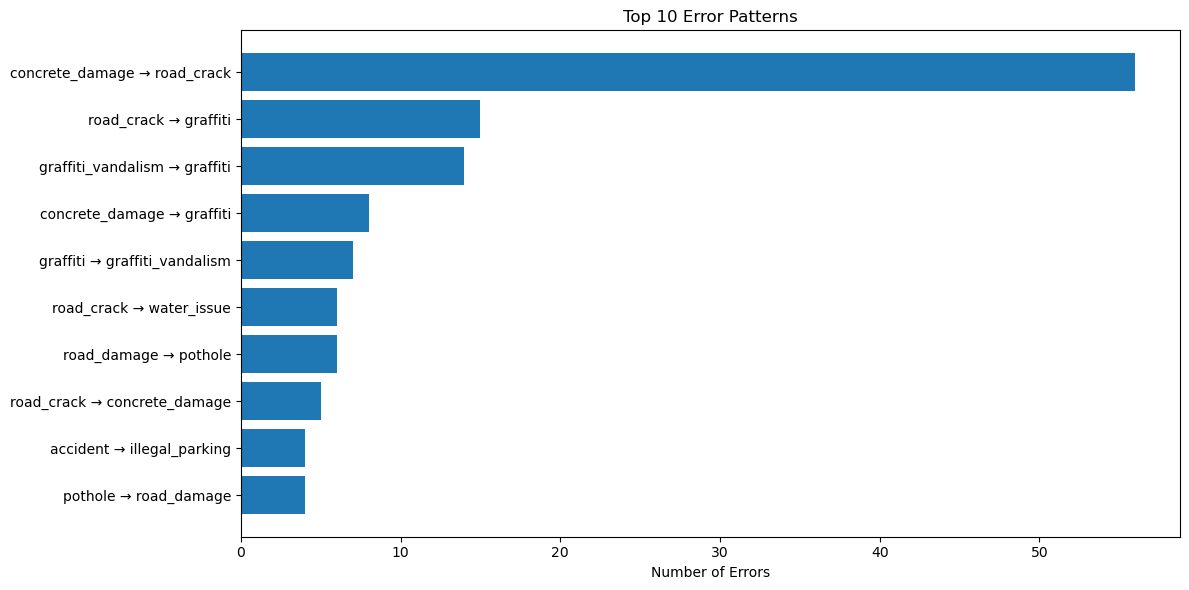

In [ ]:
def analyze_prediction_errors(true_classes, predicted_classes, class_names, test_generator):
    """Analyze prediction errors to understand model weaknesses"""
    

    misclassified_indices = np.where(true_classes != predicted_classes)[0]
    
    print(f"Total misclassified samples: {len(misclassified_indices)}")
    print(f"Error rate: {len(misclassified_indices)/len(true_classes)*100:.2f}%")
    
    # Analyze error patterns
    error_patterns = {}
    for idx in misclassified_indices:
        true_class = class_names[true_classes[idx]]
        pred_class = class_names[predicted_classes[idx]]
        error_pattern = f"{true_class} → {pred_class}"
        
        if error_pattern not in error_patterns:
            error_patterns[error_pattern] = 0
        error_patterns[error_pattern] += 1
    
    
    sorted_errors = sorted(error_patterns.items(), key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 Error Patterns:")
    print("-" * 30)
    for i, (pattern, count) in enumerate(sorted_errors[:10]):
        print(f"{i+1:2d}. {pattern}: {count} errors")
    
    
    if len(sorted_errors) > 0:
        patterns, counts = zip(*sorted_errors[:10])
        
        plt.figure(figsize=(12, 6))
        plt.barh(range(len(patterns)), counts)
        plt.yticks(range(len(patterns)), patterns)
        plt.xlabel('Number of Errors')
        plt.title('Top 10 Error Patterns')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    return error_patterns, misclassified_indices


error_patterns, misclassified_indices = analyze_prediction_errors(
    evaluation_results['true_classes'],
    evaluation_results['predicted_classes'],
    evaluation_results['class_names'],
    test_gen
)